## Chapter 8: Integrating Learning and Planning

### Model-based Reinforcement Learning

In this chapter, we focus on RL algorithms that focus on learning **model** from experiences, and use it to construct value function or policy. 

RL algorithms that mentioned in previous chapters are **model-free RL**: it directly learns value function and(or) policy. 

And there exists **model-based RL**: it learns model from experience, and plan value function and(or) policy from model.

### What is a Model?

A *Model* $\mathcal{M}$ is a representation of an MDP <$\mathcal{S}, \mathcal{A}, \mathcal{P}, \mathcal{R}$> parametrized by $\eta$. Assuming we know state space $\mathcal{S}$ and action space $\mathcal{A}$, a model $<\mathcal{P}, \mathcal{R}>$ can represent transitions
</br>
</br>
<font size="3">
$$\begin{align}
S_{t+1} \sim \mathcal{P}_\eta(S_{t+1}|S_t, A_t) \\
R_{t+1} \sim \mathcal{R}_\eta(R_{t+1}|S_t, A_t)
\end{align}$$
</font>

model $<\mathcal{P}, \mathcal{R}>$ is learned from experience ${S_1, A_1, R_2, ... , S_T}$.

Model can be parametrized in various ways: from lookup table models to deep neural networks.

For example, lookup table models  can be constructed from experiences as the following:
</br>
</br>
<font size="3">
$$\begin{align}
\hat{\mathcal{P}}_{s, s'}^a = \dfrac{1}{N(s, a)} \sum_{t=1}^T \mathbb{1}(S_t, A_t, S_{t+1} = s, a, s') \\
\hat{\mathcal{R}}_{s}^a = \dfrac{1}{N(s, a)} \sum_{t=1}^T \mathbb{1}(S_t, A_t = s, a)R_t 
\end{align}$$
</font>

where $N(s, a)$ is a visit count to each state-action pair $(s,a)$.

If the model is accurate, then we can learn value function or policy from experiences sampled from the model. Yet if not, learning from simulated experience can lead to sub-optimal policy.

### Integrating Planning, Acting and Learning

Dyna-Q algorithm is a reinforcement learning algorithm that learns value function and(or) policy from both simulated experiences from **model** and **real-world experiences**. Dyna-Q uses real-world experiment to build model, and uses model to generate simulated experiences.

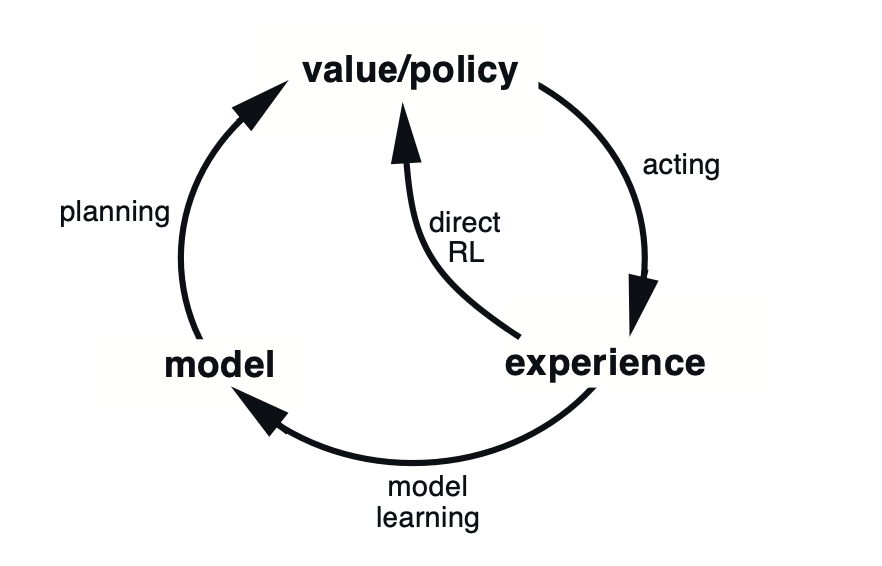 

Learning from both direct experiences and simulated experiences can help improving sample efficiency.


### Dyna-Q Psuedocode and Implementation

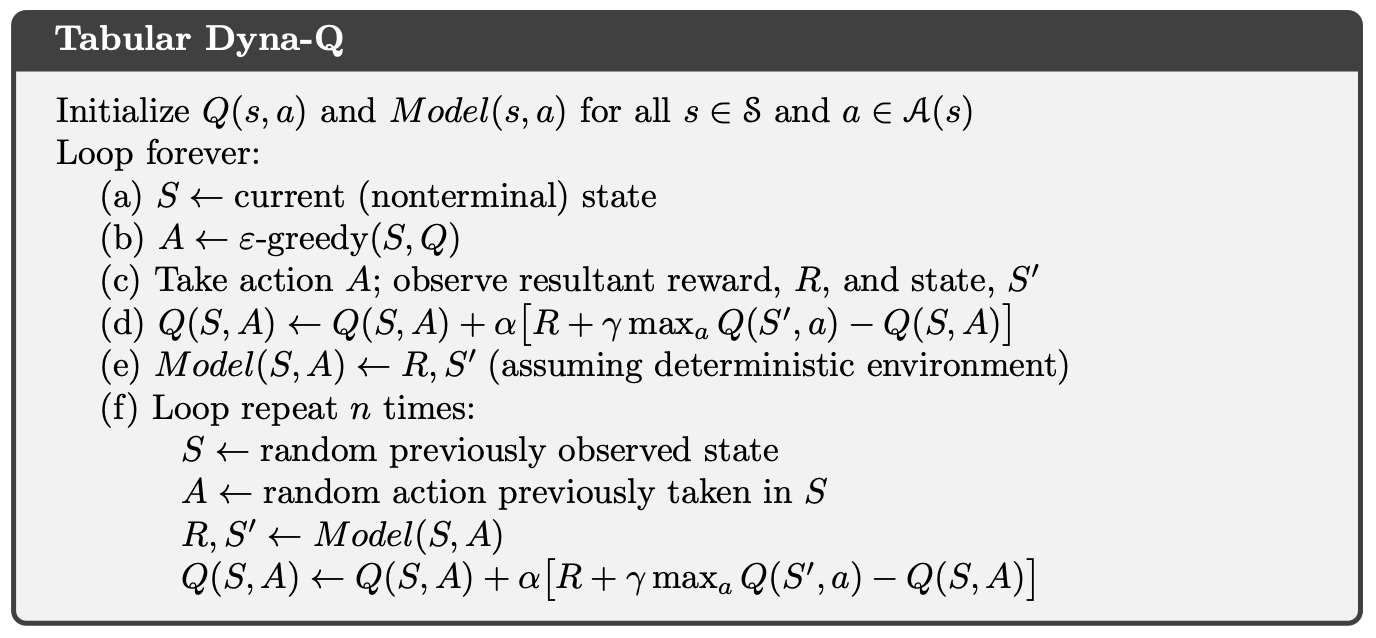

In [1]:
import gymnasium as gym
import numpy as np
from utils import JupyterRender

%matplotlib inline

In [2]:
class Dyna_Q:
    def __init__(self, env, gamma=0.8, alpha=0.1, model_n=10, eps=0.1, render=False, max_episode=1000):
        self.env = env
        self.state_dim = env.observation_space.n
        self.action_dim = env.action_space.n
        
        self.nrow = env.nrow
        self.ncol = env.ncol 
        
        self.gamma = gamma
        self.alpha = alpha
        self.model_n = model_n
        self.eps = eps
        self.max_episode = max_episode
        self.render = render
        
        self.q = np.zeros([self.state_dim, self.action_dim]) # q-value
        self.model_r = np.zeros([self.state_dim, self.action_dim]) # reward model
        self.model_ns = np.zeros([self.state_dim, self.action_dim], dtype=int) # transition model
        
    def action(self, s):
        #epsilon-greedy action
        if np.random.random() < self.eps:
            action = np.random.randint(low=0, high=self.action_dim - 1)
        else:
            action = np.argmax(self.q[s,:])

        return action
    
    def run(self):
        states = []
        actions = []
        self.success = 0

        for episode in range(self.max_episode):
            observation, _ = self.env.reset()
            done = False
            episode_reward = 0
            local_step = 0
            
            while not done:
                action = self.action(observation)
                next_observation, reward, done, _, _ = self.env.step(action)
                
                if self.render:
                    self.env.render(title=f"Episode {episode} / step {local_step}", q=self.q, model_r=self.model_r, model_ns=self.model_ns)
                    
                # give penalty for staying in ground
                if reward == 0:
                    reward = -0.001
                # give penalty for falling into the hole
                if done and next_observation != 15:
                    reward = -1

                if local_step == 100:
                    done = True #prevent infinite episode
                    reward = -1

                if observation == next_observation: # prevent meaningless actions
                    reward = -1

                episode_reward += reward
                local_step += 1
                
                # q-learning
                self.q[observation, action] = self.q[observation, action] + self.alpha*(reward + self.gamma*np.max(self.q[next_observation, :]) - self.q[observation, action])
                
                # model update
                self.model_r[observation, action] = reward
                self.model_ns[observation, action] = next_observation

                states.append(observation)
                actions.append(action)

                observation = next_observation
                
            # q-learning from samples generated in model
            for _ in range(self.model_n):
                sample = np.random.randint(low=0, high=len(states) - 1)
                s = states[sample]
                a = actions[sample]

                r = (self.model_r[s, a])
                ns = int(self.model_ns[s, a])
                self.q[s, a] = self.q[s,a] + self.alpha*(r + self.gamma*np.max(self.q[ns,:]) - self.q[s,a])

            #print("Episode: {} -> Step: {}, Episode_reward: {}".format(episode, local_step, episode_reward))
            
            if observation == 15:
                self.success += 1
                
        #print("Success rate: ", success / self.max_episode)

    

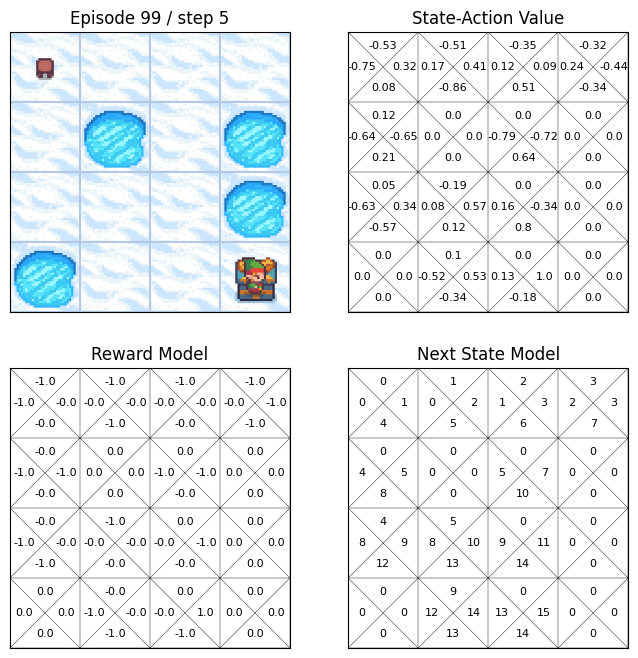

In [3]:
env = gym.make("FrozenLake-v1", render_mode='rgb_array', is_slippery=False)#define the environment.
env = JupyterRender(env)

config = {
    'env': env,
    'gamma': 0.8,
    'alpha': 0.1,
    'model_n': 10,
    'eps': 0.1,
    'render': True,
    'max_episode': 100
}

dyna_q = Dyna_Q(**config)
dyna_q.run()